In [2]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [70]:
df = pd.read_csv('data/mushroom.csv')



In [ ]:
for col in df.columns:
    df[col] = df[col].str[1:]
df = df.replace({"'":""}, regex=True)

In [ ]:
df[(df["class"] == 'p')& (df["odor"] == 'n')]

In [5]:
def ohe(df, cat_cols, cat_dictionary):
    for col in cat_cols:
        # Check if column is in the category dictionary
        
        # Get the list of categories for the column
        categories = cat_dictionary[col]
        
        # Create new column names for each category
        new_cols = [f"{col}_{c}" for c in categories]
        
        # One-hot encode the column
        one_hot = pd.get_dummies(df[col], prefix=col)
        
        # Add columns for any missing categories
        for c in new_cols:
            if c not in one_hot.columns:
                one_hot[c] = 0
        
        # Add the one-hot encoded columns to the dataframe
        df = pd.concat([df, one_hot], axis=1)
        
        # Drop the original column from the dataframe
        df.drop(columns=[col], inplace=True)
    
    return df



In [6]:
df_dict = df.to_dict(orient = 'list')
for key in df_dict.keys():
    df_dict[key] = list(set(df_dict[key]))

In [7]:
df_ohe = ohe(df, df.columns, df_dict)

In [29]:
df_ohe = df_ohe.drop("class_e", axis=1)

X = df_ohe
y = df_ohe.pop("class_p")

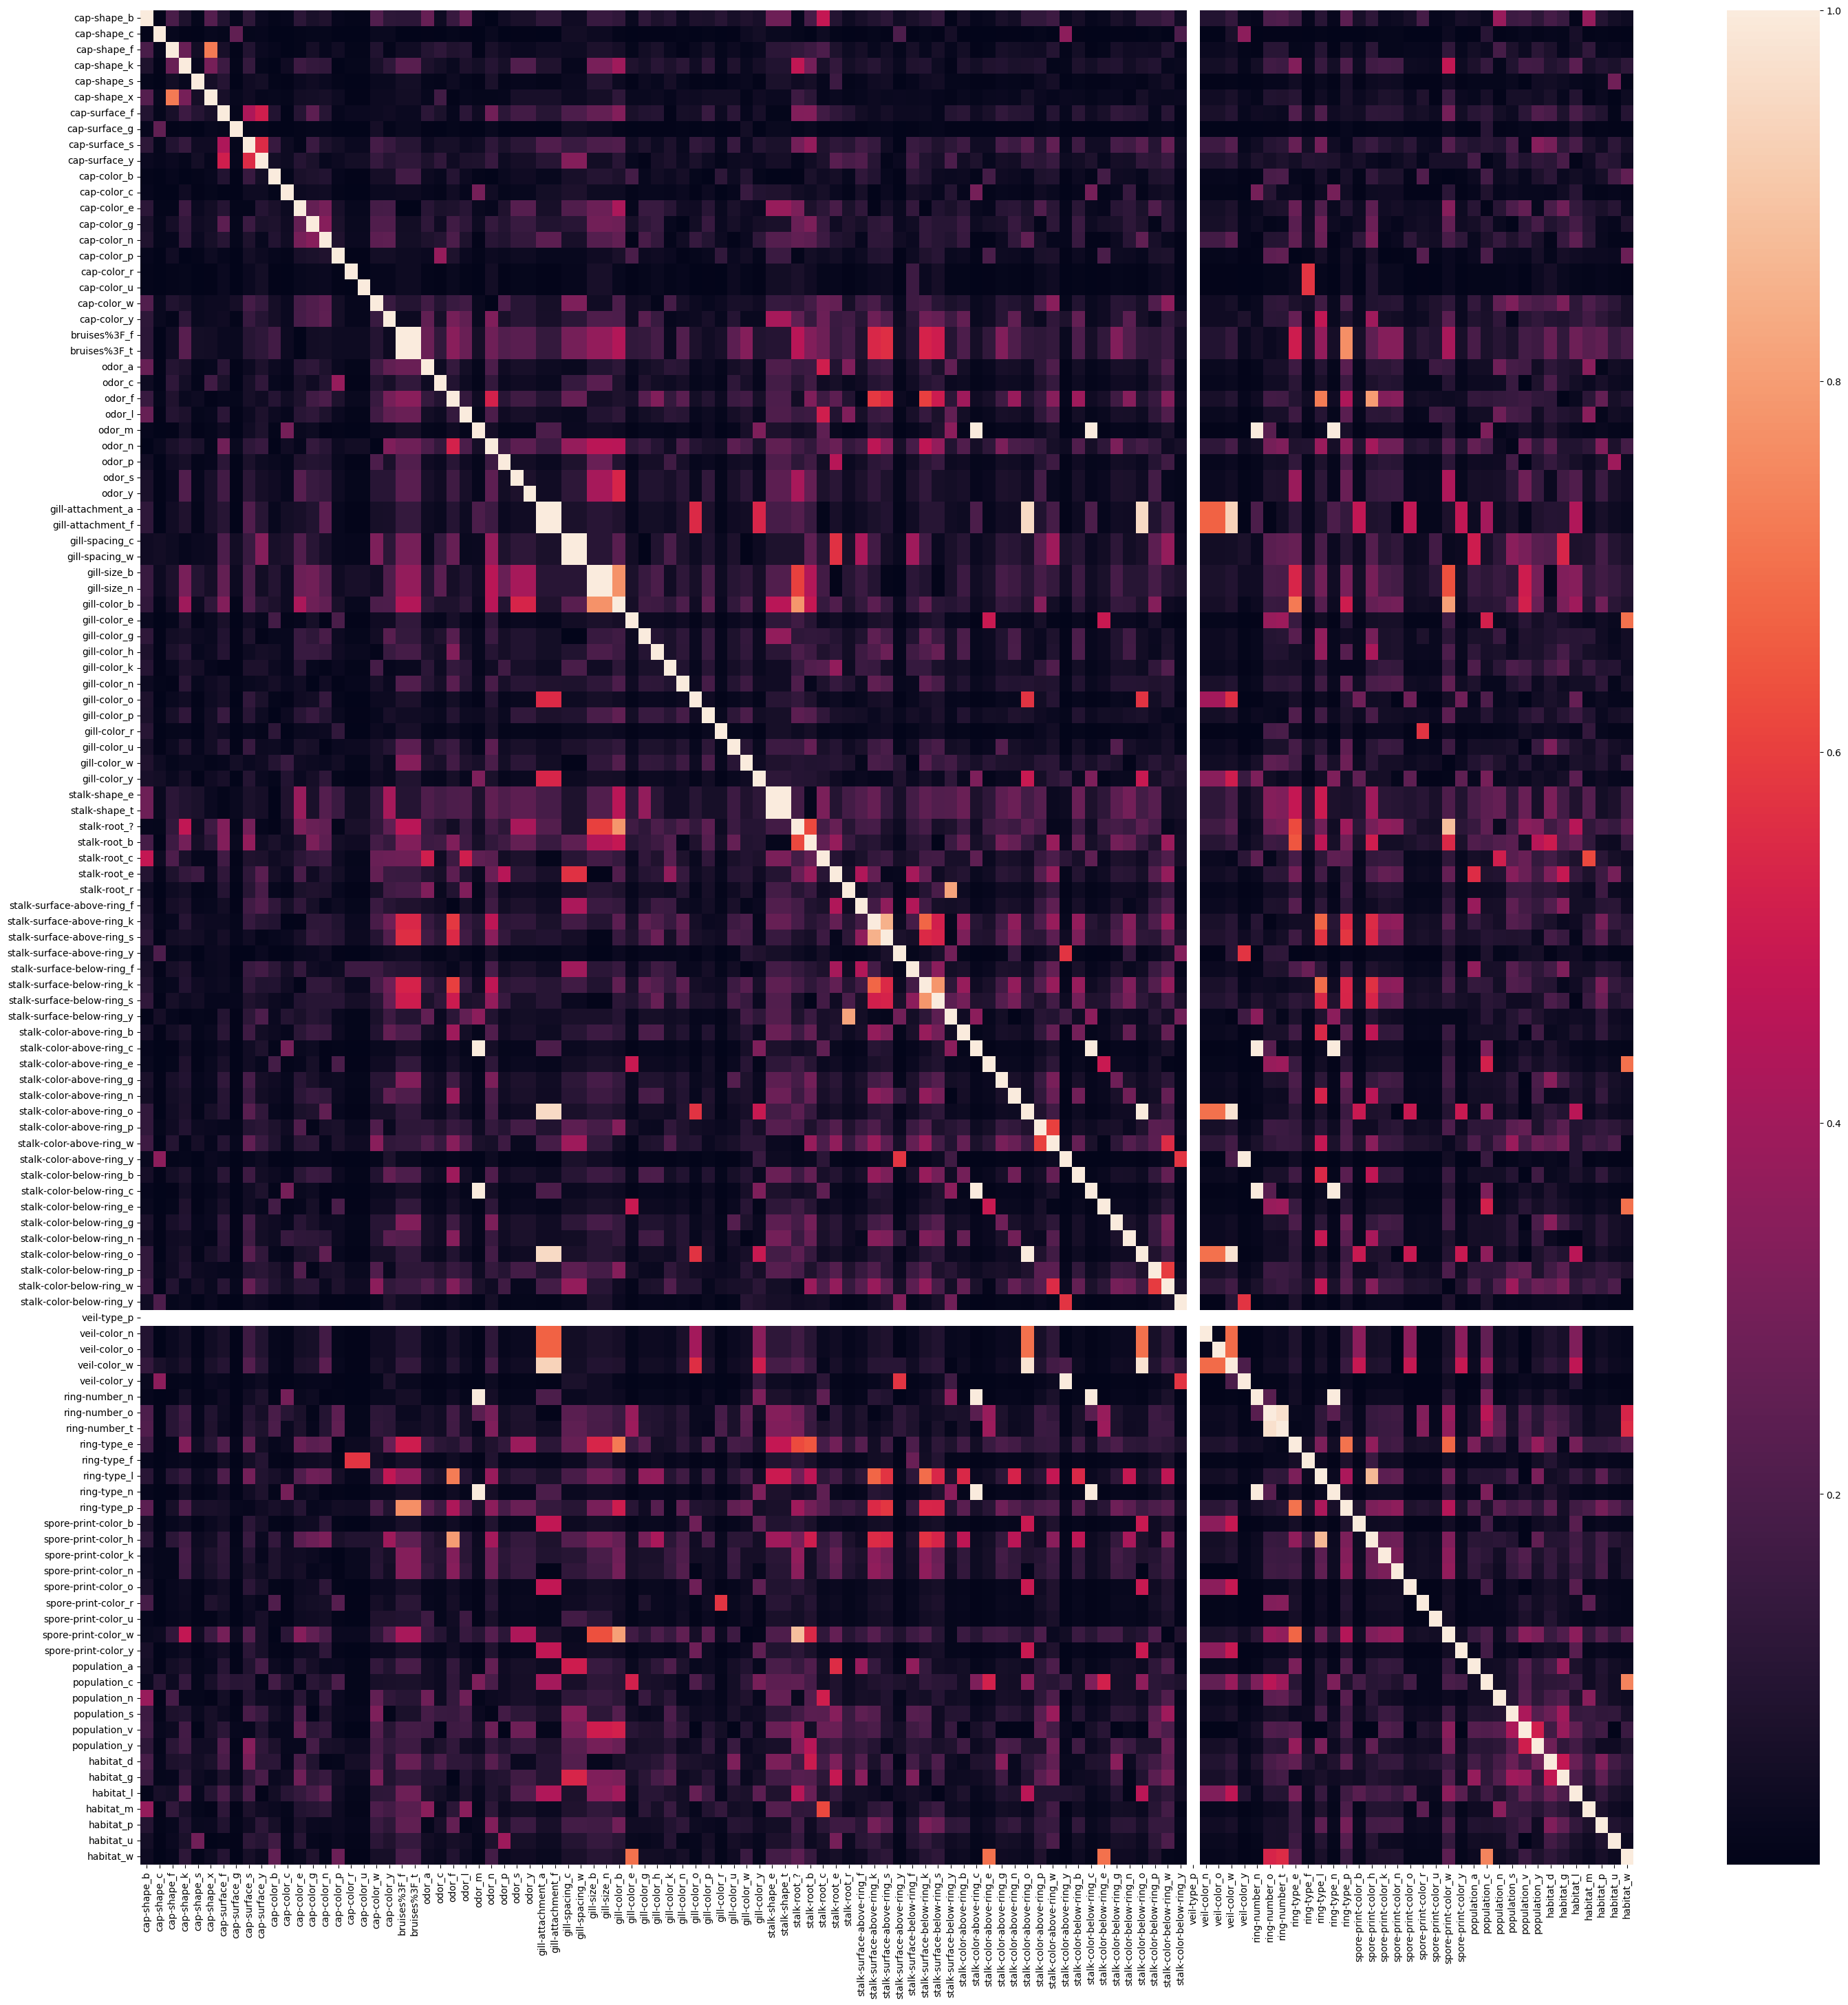

In [9]:
corr_matrix = df_ohe.corr()
fig, ax = plt.subplots(figsize = (35,35))
sns.heatmap(abs(corr_matrix))
pd.set_option('display.max_rows', None)


## Logisitc Regression 

In [30]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2)

model = LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [31]:
train_acc =model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print("Training accuracy:", train_acc)
print("Testing accuracy:", test_acc)

Training accuracy: 1.0
Testing accuracy: 1.0


In [12]:
###manually making confusion table from a different threshold
def t_repredict(est, t, xtest):
    probs = est.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return ypred

In [13]:
from sklearn.metrics import confusion_matrix
threshold = 0.5
print(confusion_matrix(y_test,t_repredict(model, threshold, X_test)))
print(confusion_matrix(y_train,t_repredict(model, threshold, X_train)))

[[809   0]
 [  0 816]]
[[3399    0]
 [   0 3100]]


In [14]:
#making ROC curves for this model
from sklearn.metrics import roc_curve, auc

#name: name of your model to appear on the figure (can be arbitrary)
#clf: the model as you named it - will be used for getting the predictions
#ytest, xtest: your test data
#skip, labe: steps that control how many points you see in the ROC curve and how many labels are there

def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM? (but double-check this pleaseee)
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    
    #this is the single value for the AUC score
    roc_auc = auc(fpr, tpr)
    
    if skip: 
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    
    #add labels to the curve
    if labe!=None:
        for k in range(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

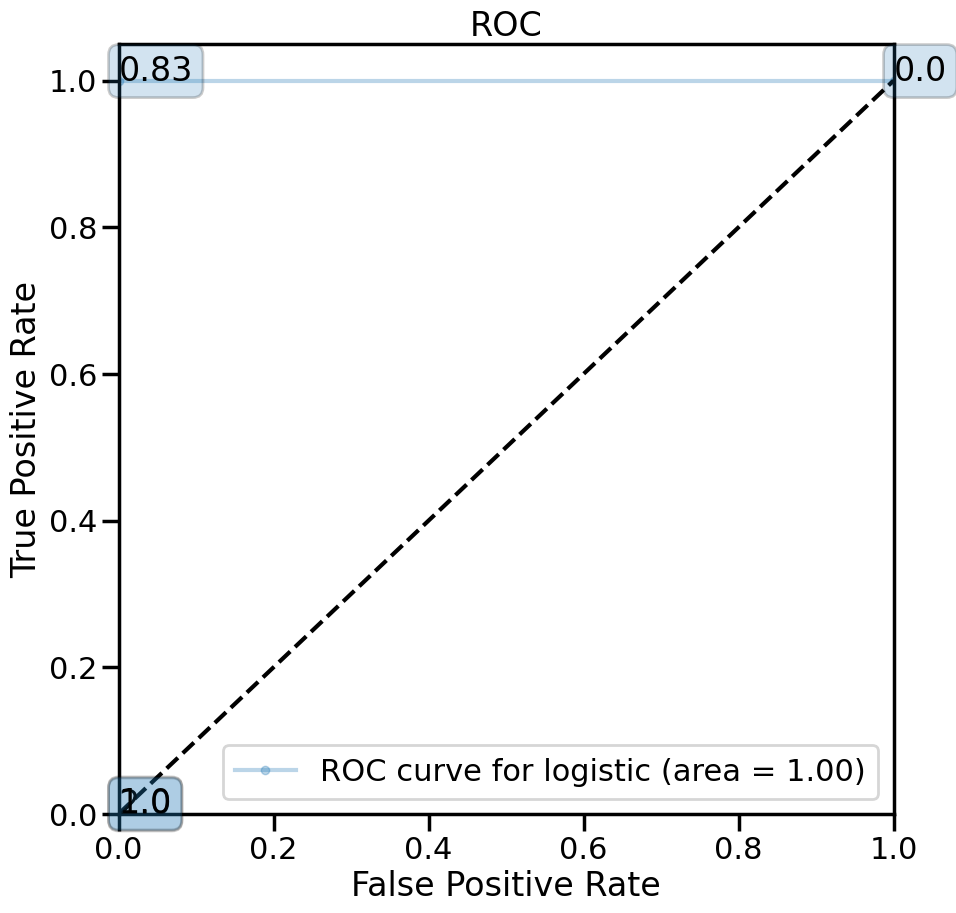

In [54]:
#This is how the above function should be used

sns.set_context("poster")
fig, ax = plt.subplots(figsize = (10,10))
ax=make_roc("logistic",model, y_test, X_test, labe=1,  skip=0)
plt.show()

# Random Forest 


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

RFmodel = RandomForestClassifier()

param_grid = {
    'n_estimators': [5, 10, 25],
    'max_depth': [None, 1, 5],
    'min_samples_split': [1, 2, 5]
}

grid_search = GridSearchCV(RFmodel, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

# Print the best hyperparameters and corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'max_depth': None, 'min_samples_split': 1, 'n_estimators': 10}
Best score:  0.961226297840091


In [16]:
grid_search.best_params_

{'max_depth': None, 'min_samples_split': 1, 'n_estimators': 10}

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


RFmodel = RandomForestClassifier(**grid_search.best_params_)


RFmodel.fit(X_train, y_train)
y_pred = RFmodel.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)


In [19]:
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       843
           1       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



In [19]:
import time
start_time = time.time()
importances = RFmodel.feature_importances_
std = np.std([tree.feature_importances_ for tree in RFmodel.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.002 seconds


Text(0, 0.5, 'Mean decrease in impurity')

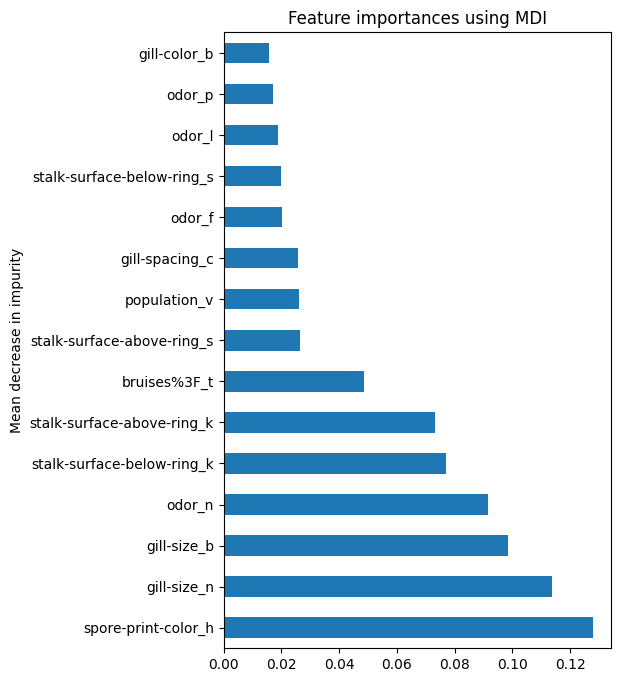

In [20]:
feature_names = [name for name in X.columns]
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize = (5,8))
forest_importances.head(15).plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


In [21]:
feature_df = forest_importances.reset_index()
feature_df[['category', 'observation']] = feature_df['index'].str.split('_', n=1, expand=True)
feature_df = feature_df[['category', 'observation', 0]]
feature_df.columns = ['category', 'observation', 'value']


Text(0, 0.5, 'Mean decrease in impurity')

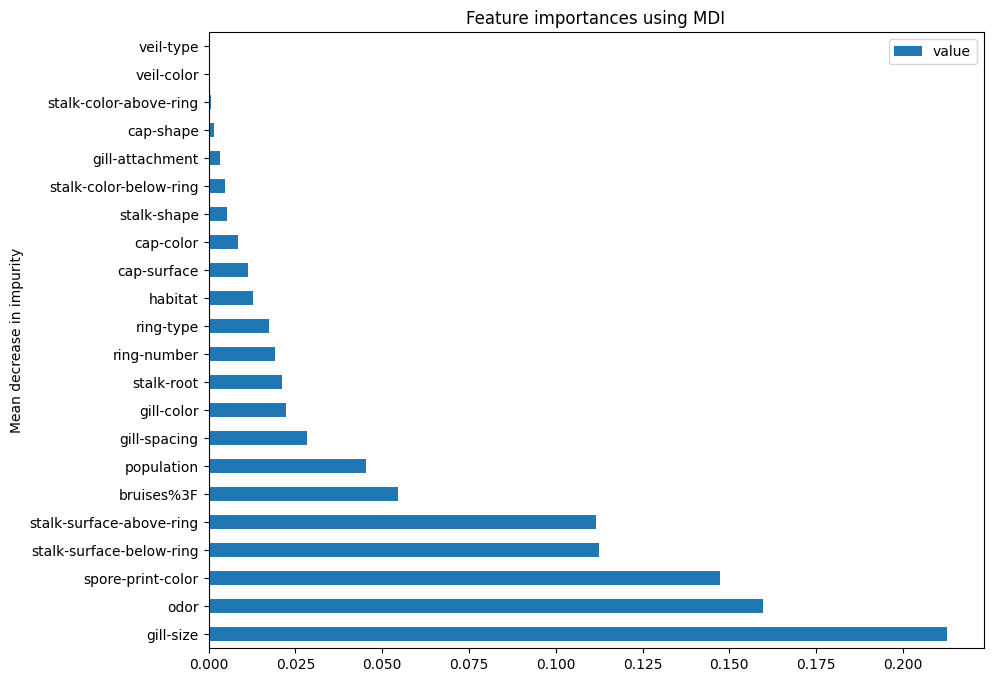

In [22]:
sorted_df = feature_df.groupby('category')['value'].sum().reset_index().sort_values('value', ascending=False)
sroted_df = sorted_df.set_index('category')
fig, ax = plt.subplots(figsize = (10,8))
sorted_df.plot.barh(x= 'category', y = 'value', ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")


In [23]:
sorted_df.set_index('category')

,value
category,
gill-size,0.212575
odor,0.159665
spore-print-color,0.147299
stalk-surface-below-ring,0.112460
stalk-surface-above-ring,0.111469
bruises%3F,0.054495
population,0.045344
gill-spacing,0.028234
gill-color,0.022409


# Reduced logisitic regression


In [24]:
df_ohe = ohe(df, df.columns, df_dict)
X = df_ohe.loc[:,"odor_a":"odor_y"]
y = df_ohe["class_p"]

In [25]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.1)

model = LogisticRegression(C=10)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [26]:
train_acc =model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print("Training accuracy:", train_acc)
print("Testing accuracy:", test_acc)

Training accuracy: 0.9850909588291615
Testing accuracy: 0.986469864698647


# Decision Tree Classifier

In [33]:
tree = DecisionTreeClassifier()

tree.fit(X=X_train,y=y_train)

y_pred_tree = tree.predict(X_test)


In [34]:
tree_train_acc =tree.score(X_train, y_train)
tree_test_acc = tree.score(X_test, y_test)

print("Training accuracy:", tree_train_acc)
print("Testing accuracy:", tree_test_acc)

Training accuracy: 1.0
Testing accuracy: 1.0


# PCA Analysis and Dimensionality Reduction

In [162]:
pca = PCA()
X_PCA = pca.fit_transform(X_train)

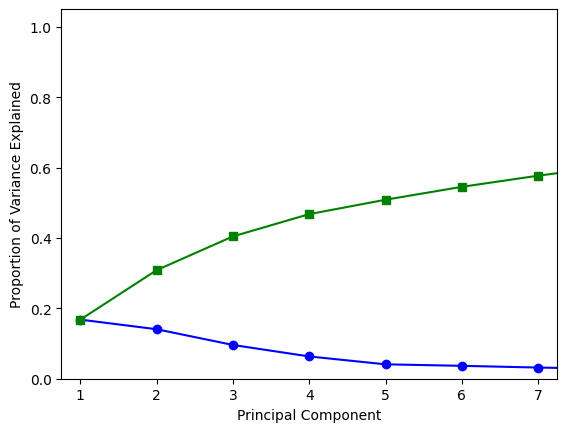

In [163]:
var_ratio = pca.explained_variance_ratio_
plt.plot(list(range(1, len(var_ratio) + 1)), var_ratio, '-o', color="blue", label='Individual component')
plt.plot(list(range(1, len(var_ratio) + 1)), np.cumsum(var_ratio), '-s', label='Cumulative', color="green")


plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,7.25)
plt.ylim(0,1.05)
plt.xticks(list(range(1, 8)))
plt.show()

The first 2 principal components hold about 35% of the variance, and may therefore be suitable for us to keep. 

In [191]:
pca = PCA(n_components = 3)
data_pca = pca.fit_transform(X_train)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3'])

In [194]:
import plotly.express as px
x_plot = np.array(data_pca)[:,0]
y_plot = np.array(data_pca)[:,1]
fig = px.scatter(x=x_plot,y = y_plot, color = y_train)
fig.update_layout(
    xaxis_title="PC1",
    yaxis_title="PC2",
    legend_title="Poisonous"
)
fig.show()


The figure above depics the first principal component plotted against the second. Here we can see some distinct clusters, within the positive values and the negative values, indicating that there may be a clear distinction with our selected components. We can test the accuracy of our PCA model by using a K-nearest neighbors classifier.

In [192]:
from sklearn.neighbors import KNeighborsClassifier

data_pca_test = pca.fit_transform(X_test)
data_pca_test = pd.DataFrame(data_pca_test,columns=['PC1','PC2','PC3'])

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(data_pca,y_train)
knn.score(data_pca_test,y_test)

0.9107692307692308